In [1]:
from tifffile import imread
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import cv2
%matplotlib notebook
from mpl_toolkits import mplot3d
import scipy.signal as scps
import pandas as pd
from miniscope_tiffs import scroll_images, get_all_CropROIs, GetMiniscopeDirs, load_miniscope_avis
import copy
import pandas
import os
import glob
import json


In [2]:
animals = ['Hipp16942'] # ['Hipp16941', 'Hipp16942', 'Hipp16943']
topdir = 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/'
mini_name = 'msCam.tiff'
behav_name = '../experiment/behav_position_data.csv' # 'behavCam.tiff'
onlytiff = False # True or False or None

MiniFolders, BehavFolders, parentMiniFolders, parentBehavFolders = \
    GetMiniscopeDirs(topdir, animals, TiffDirsOnly=onlytiff, miniscope_tiff_name=mini_name, behavcam_tiff_name=behav_name)
BehavFolders

['C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_25_10/BehavCam',
 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_32_52/BehavCam',
 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_44_02/BehavCam']

In [4]:
# imname = str(BehavFolders[0] + '/behavCam.tiff')
# im = imread(imname)
# scroll_images(im)

In [64]:
use_old_crops = True
# Do this to try and use old circle definition, if they exist
if use_old_crops==True:
    import re
    cropROIs = {}
    maskROIs = {}
    for sessDir in parentBehavFolders:
        outParamsFile = str(sessDir + 'experiment/behav_ext_params.json')
        roiKey       = str(sessDir + 'BehavCam')
        with open(outParamsFile, "r") as outfile:
            dict_temp = json.load(outfile)
        center = dict_temp['center']
        b = re.search(',', center)
        c1 = int(center[1:b.start()])
        c2 = int(center[b.end()+1:-1])
        center = (c1, c2)
        radius = dict_temp['radius']
        radius = int(radius)
        maskROIs[roiKey] = [center, radius]
else: # generate new ones
    video_name = '' # expression labelling miniscope avi files, such as 'msCam' (if 'msCam1.avi', 'msCam2.avi',...)
                    # or '' (if '0.avi', '1.avi', etc). Starts at the lowest and goes to the highest
    crop_shape = 'circle' #'sq' # 'rect' # 'circle', 'rectangle', or 'square'. For no cropping: crop_shape=[]
    verbose = False # more or less print details
    cropROIs, maskROIs  = get_all_CropROIs(BehavFolders, avi_names=video_name, shape=crop_shape, verbose=verbose, load_all=True)
maskROIs


{'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_25_10/BehavCam': [(151,
   146),
  103],
 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_32_52/BehavCam': [(147,
   149),
  102],
 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_44_02/BehavCam': [(146,
   148),
  102]}

In [65]:
def eval_mask_pos(im, thresh=255, min_area=10, verbose=False):
    yi = 0
    xi = 0
    mask       = im >= thresh
    if mask.any(0).any(0): # any(np.sum(np.sum(mask))>0):
        label_im, nb_labels = ndimage.label(mask)
        # calculate various image properties of the remaining ROIs
        sizes      = ndimage.sum(mask, label_im, range(nb_labels + 1))
        max_vals   = ndimage.maximum(im, label_im, range(nb_labels + 1))
        mean_vals  = ndimage.mean(im, label_im, range(nb_labels + 1))
        # LED size thresholding
#         if verbose:
#             print('LOG: sizes=  ' + str(sizes))
#             print('LOG: maxes=  ' + str(max_vals))
#             print('LOG: means=  ' + str(mean_vals))
        c = sizes >= min_area
        if any(c):
            tempind   = np.argwhere(c)
            sizes     = sizes[tempind[0]]
            max_vals  = max_vals[tempind[0]]
            mean_vals = mean_vals[tempind[0]]
            label_im = label_im[tempind[0]]
#             nb_labels = nb_labels[tempind[0]]
            # LED max and mean value must must the greatest of the ROIs
            a = np.max(max_vals)==max_vals
            b = np.max(mean_vals)==mean_vals
            if any(a==b): # testing that it has the max max and the max mean values
                tempind = np.argwhere(a==b)
                good_ind = tempind[0][0]
                com = ndimage.center_of_mass(mask, label_im, range(nb_labels + 1))
                yi, xi = com[good_ind]  
                if verbose:
                    print('LOG: com=  ' + str(com))
                    print('LOG: goodind=  ' + str(good_ind))
                    print('LOG: com[good_ind]=  ' + str(com[good_ind]))
                    print('LOG: xi=  ' + str(xi))
                    print('LOG: yi=  ' + str(yi))
            else:
                if verbose: print('! LOG: max of [means] and [max_vals] not concordant')
        else:
            if verbose: print('! LOG: No spots bigger than min_area: ' + str(min_area))
    else:
        if verbose: print('! LOG: No ROI after mask thresh: ' + str(thresh))

    return yi, xi

def extract_pos_APA(bmat, thresh=255, min_area=10,  inner_valid=None, outer_valid=None, sticky_win=100, verbose=False):
    frames, h, w = bmat.shape
    
    x = np.zeros(frames) # column index
    y = np.zeros(frames) # row index
    arena_x = np.zeros(frames) # column index
    arena_y = np.zeros(frames) # row index
    ind = 0
    
    if inner_valid is None:
        inner_valid = np.ones((h, w), dtype='uint8')
    if outer_valid is None:
        outer_valid = np.zeros((h, w), dtype='uint8')
    for im in bmat:
        # first mask the image by the threshold
        imtemp = copy.deepcopy(im)
        # I want to align it with the BSG caerma, 180 rotation
        #     imtemp = list(zip(*imtemp[::-1])) # 90 degree rotation
        #     imtemp = list(zip(*imtemp[::-1])) # 90 degree rotation
        im_inside = copy.deepcopy(imtemp)
        im_outside = copy.deepcopy(imtemp)
        im_inside[inner_valid==0] = 0
        im_outside[outer_valid==0] = 0
        ## CALCULATE RAT LED POSITION
        if verbose:
            print('~~~ INSIDE, FRAME =  ' + str(ind))
        yi, xi = eval_mask_pos(im=im_inside, thresh=thresh, min_area=min_area, verbose=verbose)
        y[ind] = yi
        x[ind] = xi
        if verbose:
            print('~~~ OUTSIDE, FRAME =  ' + str(ind))
        yi, xi = eval_mask_pos(im=im_outside, thresh=thresh, min_area=min_area, verbose=verbose)
        arena_y[ind] = yi
        arena_x[ind] = xi
        # print the percent done in 10
        if ((ind)%(np.round(frames*.1))==0) and (ind>0):
            print('~ frame: ' + str(ind) + ',  ' + str(np.round(100*ind/frames).astype('int')) + '%')

        ind = ind+1
    return x, y, arena_x, arena_y

def interp_and_smooth(x,y,smoothing_size):
    xi = x
    yi = y
    #
    a = xi==0
    b = yi==0
    c = a==b
    xq = np.where(a==c)
    #
    a = xi!=0
    b = yi!=0
    c = a==b
    x0 = np.where(a==c)
    xv = xi[x0]
    yv = yi[x0]
    #
    x1 = np.interp(xq, x0[0], xv)
    y1 = np.interp(xq, x0[0], yv)
    #
    #
    xi[xq] = x1[0]
    yi[xq] = y1[0]
    #
    xi = scps.medfilt(xi, kernel_size=smoothing_size)
    yi = scps.medfilt(yi, kernel_size=smoothing_size)
    #
    xt = np.zeros(len(x)+1)
    yt = np.zeros(len(y)+1)
    xt[1::] = xi # increase size by one to account for diff
    yt[1::] = yi # increase size by one to account for diff
    xt[0] = xi[0]
    yt[0] = yi[0]
    #
    xd = np.diff(xt, n=1)
    yd = np.diff(yt, n=1)
    speed = np.sqrt((xd**2 + yd**2))
    return xi, yi, speed

In [66]:
parentBehavFolders

['C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_25_10/',
 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_32_52/',
 'C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_44_02/']

In [70]:
# for higher gain sessions
# thresh = 230 # luminance value to consider (led >= thresh)
# min_area = 2 # minimum area to consider
# for early session when very dark
thresh = 20 # luminance value to consider (led >= thresh)
min_area = 2 # minimum area to consider
verbose = False
for sessDir in parentBehavFolders:
    behavDir = str(sessDir + 'BehavCam/')
    vidName = str(behavDir + 'behavCam.tiff')
    outFileName = str(sessDir + 'experiment/behav_position_data.csv')
    if True: # os.path.isfile(outFileName)==False:
        timestampFile_bh = str(behavDir + 'timeStamps.csv')
        timestampFile_ms = str(sessDir + 'MiniLFOV/timeStamps.csv')

        ms_dat = pd.read_csv(timestampFile_ms)
        ms_t = ms_dat['Time Stamp (ms)']
        beh_dat = pd.read_csv(timestampFile_bh)
        beh_t = beh_dat['Time Stamp (ms)']
        print('~~~ Loading tiff file: ' + vidName)
        bmat = imread(vidName)
        #     bg = np.max(bmat, axis=0).astype('u8')

        numFrames, h, w = bmat.shape
        tds = np.round(len(beh_t)/numFrames).astype(int)
        tds
        beh_t = beh_t[::tds]
        behav_dt = np.median(np.abs(np.diff(beh_t, n=1)))
        behav_dt
        behav_fps = np.round(1000/behav_dt)

        sillyDir = behavDir = str(sessDir + 'BehavCam')
        circleDef = maskROIs[sillyDir]
        center = circleDef[0]
        radius = circleDef[1]
        Y, X = np.ogrid[:h, :w]

        dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)
        inner_valid = dist_from_center <= radius
        outer_valid = dist_from_center > radius*1.15

        # extract the LED positions
        print('~~~ Extracting position... ' + str(numFrames) + ' frames')
        x, y, arena_x, arena_y = extract_pos_APA(bmat, thresh, min_area, inner_valid, outer_valid, verbose=verbose)
        timestamps  = beh_t
        
        D = {'x':x, 'y':y, 'arena_x':arena_x, 'arena_y':arena_y, 'timestamps':timestamps}
        DD = pd.DataFrame(D)
        DD.to_csv(outFileName)
        
        dictionary ={
            'center': str(center),
            'radius': str(radius),
            'behav_dt' : str(behav_dt),
            'behav_fps': str(behav_fps),
            'numFrames': str(numFrames),
            'h': str(h),
            'w': str(w),
            'thresh': str(thresh),
            'min_area': str(min_area)
        }
        outParamsFile = str(sessDir + 'experiment/behav_ext_params.json')
        with open(outParamsFile, "w") as outfile:
            json.dump(dictionary, outfile)

        print('~~~ Data saved to:  ' + outFileName)
        print('~~~ Data params saved to:  ' + outParamsFile)
    else:
        print('~~~ SKIPPING:  ' + outFileName)


~~~ Loading tiff file: C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_25_10/BehavCam/behavCam.tiff
~~~ Extracting position... 9916 frames


C:\Users\gjb326\Anaconda3\envs\caiman\lib\site-packages\scipy\ndimage\_measurements.py:1407: RuntimeWarning: invalid value encountered in true_divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


~ frame: 992,  10%
~ frame: 1984,  20%
~ frame: 2976,  30%
~ frame: 3968,  40%
~ frame: 4960,  50%
~ frame: 5952,  60%
~ frame: 6944,  70%
~ frame: 7936,  80%
~ frame: 8928,  90%
~~~ Data saved to:  C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_25_10/experiment/behav_position_data.csv
~~~ Data params saved to:  C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_25_10/experiment/behav_ext_params.json
~~~ Loading tiff file: C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_32_52/BehavCam/behavCam.tiff
~~~ Extracting position... 9383 frames


C:\Users\gjb326\Anaconda3\envs\caiman\lib\site-packages\scipy\ndimage\_measurements.py:1407: RuntimeWarning: invalid value encountered in true_divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


~ frame: 938,  10%
~ frame: 1876,  20%
~ frame: 2814,  30%
~ frame: 3752,  40%
~ frame: 4690,  50%
~ frame: 5628,  60%
~ frame: 6566,  70%
~ frame: 7504,  80%
~ frame: 8442,  90%
~ frame: 9380,  100%
~~~ Data saved to:  C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_32_52/experiment/behav_position_data.csv
~~~ Data params saved to:  C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_32_52/experiment/behav_ext_params.json
~~~ Loading tiff file: C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_44_02/BehavCam/behavCam.tiff
~~~ Extracting position... 19782 frames


C:\Users\gjb326\Anaconda3\envs\caiman\lib\site-packages\scipy\ndimage\_measurements.py:1407: RuntimeWarning: invalid value encountered in true_divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


~ frame: 1978,  10%
~ frame: 3956,  20%
~ frame: 5934,  30%
~ frame: 7912,  40%
~ frame: 9890,  50%
~ frame: 11868,  60%
~ frame: 13846,  70%
~ frame: 15824,  80%
~ frame: 17802,  90%
~ frame: 19780,  100%
~~~ Data saved to:  C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_44_02/experiment/behav_position_data.csv
~~~ Data params saved to:  C:/Users/gjb326/Desktop/RecordingData/GarrettBlair/APA_aquisition/Hipp16942/2022_06_10/18_44_02/experiment/behav_ext_params.json


In [ ]:
# Looking at different ways of determining threshold
a999 = np.zeros([frames, 1])
a90 = np.zeros([frames, 1])
a95 = np.zeros([frames, 1])
a99 = np.zeros([frames, 1])

ind = 0
for im in bmat:
    v = im[im>0]
    a999[ind] = np.quantile(v, q=.999)
    a90[ind] = np.quantile(v, q=.9)
    a95[ind] = np.quantile(v, q=.95)
    a99[ind] = np.quantile(v, q=.99)
    
    ind = ind+1
    
plt.plot(a999)
plt.plot(a99)
plt.plot(a95)
plt.plot(a90)

In [ ]:
scroll_images(bmat)

In [ ]:
im
# mrthod from https://stackoverflow.com/questions/8421337/rotating-a-two-dimensional-array-in-python
imt1 = list(zip(*im[::-1]))
imt2 = list(zip(*imt1[::-1]))
## SHOULD ROTATE 180 TO ALIGN WITH BSG CAM

imrot = np.hstack((im, imt1, imt2))
plt.figure()
plt.imshow(imrot)

<IPython.core.display.Javascript object>


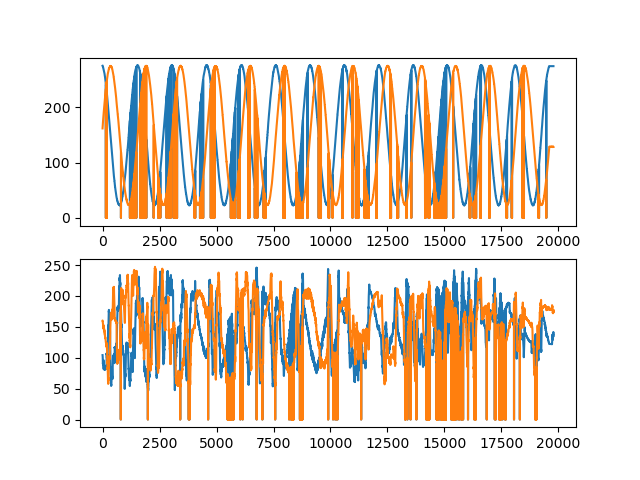

In [71]:
ind = len(x)
plt.figure()
plt.subplot(2,1,1)
plt.plot(np.arange(0,ind), arena_x[0:ind])
plt.plot(np.arange(0,ind), arena_y[0:ind])


plt.subplot(2,1,2)
plt.plot(np.arange(0,ind), x[0:ind])
plt.plot(np.arange(0,ind), y[0:ind])

In [ ]:
# # half second smoothing size
# smoothing_size = np.round(behav_fps/2).astype('int')
# if np.mod(smoothing_size,2)==0:
#     smoothing_size = smoothing_size+1 # odd size for kernel
    
# xi, yi, speed                   = interp_and_smooth(x,y,smoothing_size)
# arena_xi, arena_yi, arena_speed = interp_and_smooth(arena_x,arena_y,smoothing_size)

# x1
fig = plt.figure();
# plt.plot(s);
plt.subplot(2,1,1)
plt.plot(x);
plt.plot(y*-1);
plt.plot(xi);
plt.plot(yi*-1);

plt.subplot(2,1,2)
plt.plot(speed);

# plt.plot(t[1::], xd);

In [ ]:


fig = plt.figure()
ax1 = plt.axes(projection='3d')
# ax.scatter(x, y, beh_t, c='grey', s=2)
# ax.scatter(xi, yi, beh_t, c='red', s=2)
ax1.plot3D(arena_x, arena_y, beh_t, 'gray')

# ax2 = plt.axes(projection='3d')
ax1.plot3D(xi, yi, beh_t, 'r')



In [ ]:
outFileName

In [ ]:
# x = x.flatten(order='C')
# y = y.flatten(order='C')
behav_dt  = np.round(behav_dt).astype( 'uint16')
behav_fps  = np.round(behav_fps).astype( 'uint16')
timestamps  = np.round(beh_t).astype( 'uint16')
x  = np.round(x).astype( 'uint16')
xi = np.round(xi).astype('uint16')
y  = np.round(y).astype( 'uint16')
yi = np.round(yi).astype('uint16')
speed  = speed.astype( 'float32')
arena_x  = np.round(arena_x).astype( 'uint16')
arena_xi = np.round(arena_xi).astype('uint16')
arena_y  = np.round(arena_y).astype( 'uint16')
arena_yi = np.round(arena_yi).astype('uint16')
arena_speed  = arena_speed.astype( 'float32')

D = {'x_raw':x, 'x':xi, 'y_raw':y, 'y':yi, 'speed':speed, 
     'arena_x_raw':arena_x, 'arena_x':arena_xi, 'arena_y_raw':arena_y, 'arena_y':arena_yi, 'arena_speed':arena_speed,
    'behav_dt':behav_dt, 'behav_fps':behav_fps, 'timestamps':timestamps}
DD = pd.DataFrame(D)
DD.to_csv(outFileName)

In [ ]:

DD.to_csv(outFileName)

In [ ]:
im_all = None
ind = 0
for im in bmat:
    # first mask the image by the threshold
    imtemp = copy.deepcopy(im)
    # I want to align it with the BSG caerma, 180 rotation
#     imtemp = list(zip(*imtemp[::-1])) # 90 degree rotation
#     imtemp = list(zip(*imtemp[::-1])) # 90 degree rotation
    
    im_inside = copy.deepcopy(imtemp)
    im_outside = copy.deepcopy(imtemp)
    im_inside[outer_mask] = 0
    im_outside[outer_mask==False] = 0    
    ## DO THE SAME FOR THE ARENA POSITION
    mask       = im_outside >= thresh
    label_im, nb_labels = ndimage.label(mask)
    # calculate various image properties of the remaining ROIs
    sizes      = ndimage.sum(mask, label_im, range(nb_labels + 1))
    max_vals   = ndimage.maximum(im, label_im, range(nb_labels + 1))
    mean_vals  = ndimage.mean(im, label_im, range(nb_labels + 1))
    
    # LED max and mean value must must the greatest of the ROIs
    a = np.max(max_vals)==max_vals
    b = np.max(mean_vals)==mean_vals
    c = sizes>= min_area
    if any(a==b): # testing that it has the max max and the max mean values
        q = a==b
        v = a==True
        tempind = np.argwhere(q==v)
        good_ind = tempind[0][0]
        # LED size thresholding
        if sizes[good_ind]>=min_area:
            # extract the center of mass
            com = ndimage.center_of_mass(mask, label_im, range(nb_labels + 1))
            arena_y[ind], arena_x[ind] = com[good_ind]            
            
    imh = np.hstack((im, mask*255))
    if im_all is None:
        im_all  = np.empty([bmat.shape[0], im.shape[0], im.shape[1]*2], dtype=np.uint8)
    im_all[ind] = imh
    
    
    
    ind = ind+1

In [ ]:
plt.figure()
plt.imshow(np.hstack((im, outer_mask*255)))

In [ ]:
scroll_images(im_all)